129L Section 2 <br>
1/14-16/25 <br>
William Melby

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from mpl_toolkits.mplot3d import Axes3D
import csv
import time 

**Task 1**: Convex hull in 2D

Part 1: Build Algorithms

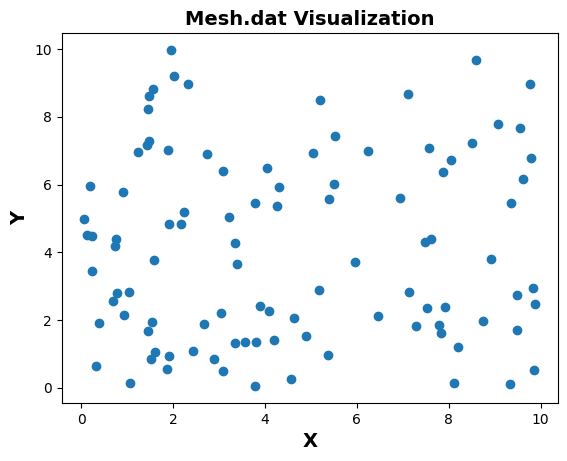

In [2]:
# Load the .dat file
data = pd.read_csv("mesh.dat", delimiter=" ")  # Adjust the delimiter based on file format

# Plot the data
plt.plot(data['X'], data['Y'], marker='o', linestyle=' ')
plt.xlabel("X", fontsize=14, fontweight='bold')
plt.ylabel("Y", fontsize=14, fontweight='bold')
plt.title("Mesh.dat Visualization", fontsize=14, fontweight='bold')
plt.show()

In [3]:
print(data)

           X         Y
0   7.886064  6.359793
1   2.321047  8.954139
2   0.241770  4.484384
3   8.585893  9.667951
4   0.733972  4.184429
..       ...       ...
95  2.225854  5.189698
96  3.088985  0.506305
97  0.907754  5.776031
98  5.203489  8.485519
99  3.223847  5.037382

[100 rows x 2 columns]


In [4]:
def get_cross_product(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

In [5]:
def get_slope(p1, p2):
    if p1[0] == p2[0]:
        return float('inf')
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

In [6]:
# 2D Graham Scan
def compute_convex_hull(points):
    # Step 1: Sort the points
    points.sort(key=lambda x: (x[0], x[1]))
    
    # Step 2: Get the start point (lowest lexicographical point)
    start = points.pop(0)
    hull = [start]

    # Step 3: Sort remaining points based on polar angle with the start point
    points.sort(key=lambda p: (get_slope(start, p), p[1], p[0]))

    # Step 4: Build the hull
    for pt in points:
        hull.append(pt)
        # Ensure convexity by checking the cross product
        while len(hull) > 2 and get_cross_product(hull[-3], hull[-2], hull[-1]) < 0:
            hull.pop(-2)
    
    return hull

In [14]:
# (not enough time to finish the other methods)

In [8]:
def read_points_from_file(filename):
    points = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=' ')
        next(reader)  # Skip the first row (header)
        for row in reader:
            # Convert the x, y values to floats and append as a tuple
            points.append((float(row[0]), float(row[1])))
            
    return points

In [10]:
points = read_points_from_file('mesh.dat')
print(points)

[(7.886064, 6.359793), (2.321047, 8.954139), (0.24177, 4.484384), (8.585893, 9.667951), (0.733972, 4.184429), (0.066917, 4.989909), (5.171782, 2.894169), (7.783637, 1.84363), (3.079366, 6.398785), (1.554935, 8.822333), (7.565876, 7.070832), (9.360976, 5.455807), (8.49718, 7.212187), (5.398867, 5.557717), (0.220598, 3.450224), (1.905661, 4.84865), (0.937792, 2.15556), (3.774648, 0.053429), (0.686874, 2.569727), (4.6301, 2.044686), (2.014782, 9.196666), (1.952346, 9.973366), (1.598117, 1.064985), (2.726009, 6.897824), (9.075066, 7.777463), (7.286463, 1.818542), (1.482872, 8.62572), (3.355591, 1.313981), (9.791283, 6.778667), (9.339696, 0.11398), (0.128699, 4.507505), (1.241003, 6.952584), (9.490763, 1.718606), (6.946763, 5.600338), (4.204096, 1.409201), (7.910727, 2.396039), (4.078636, 2.251945), (7.132603, 2.817208), (0.381927, 1.908477), (1.475566, 7.283013), (3.347119, 4.274362), (7.524107, 2.346317), (5.964628, 3.712528), (3.568954, 1.358731), (2.177939, 4.827777), (3.891618, 2.39865

In [11]:
hull = compute_convex_hull(points)
print(hull)

[(0.066917, 4.989909), (0.318775, 0.628921), (1.057869, 0.128336), (3.774648, 0.053429), (9.339696, 0.11398), (9.856832, 0.523261), (9.887099, 2.484264), (9.761306, 8.978739), (8.585893, 9.667951), (1.952346, 9.973366), (0.178674, 5.95617)]


In [12]:
def plot_points_with_hull(points, hull):
    # Separate the points on the convex hull from the others
    hull_set = set(hull)
    non_hull_points = [pt for pt in points if pt not in hull_set]
    
    # Plot all points (non-hull points in one color)
    x_non_hull, y_non_hull = zip(*non_hull_points) if non_hull_points else ([], [])
    plt.scatter(x_non_hull, y_non_hull, color='blue', label='Non-Hull Points')
    
    # Plot the convex hull points (different color, connected by lines)
    x_hull, y_hull = zip(*hull)
    plt.plot(x_hull + (x_hull[0],), y_hull + (y_hull[0],), color='red', label='Convex Hull')
    plt.scatter(x_hull, y_hull, color='red', marker='o', label='Hull Points')
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Convex Hull of Points')
    plt.legend()
    plt.grid(True)
    plt.show()

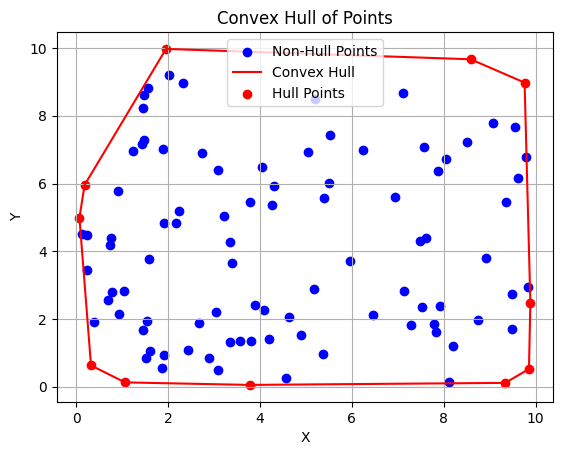

In [13]:
plot_points_with_hull(points, hull)

Part 2

In [33]:
def generate_random_points(n, x_range=(0, 1), y_range=(0, 1)):
    points = [(random.uniform(x_range[0], x_range[1]), random.uniform(y_range[0], y_range[1])) for _ in range(n)]
    return points

In [34]:
# part b. 
n_values = [10, 50, 100, 200, 400, 800, 1000]

In [35]:
def measure_time_to_compute_hull(points):
    start_time = time.time()  # Start the timer
    hull = compute_convex_hull(points)
    end_time = time.time()  # End the timer
    
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    return elapsed_time

In [36]:
times = []

# Loop over each value of n
for n in n_values:
    # Generate random points
    points = generate_random_points(n)
    
    # Measure the time taken to compute the convex hull
    elapsed_time = measure_time_to_compute_hull(points)
    
    # Store the result
    times.append(elapsed_time)

print(times)

[3.981590270996094e-05, 0.0001621246337890625, 0.00032591819763183594, 0.000701904296875, 0.0013349056243896484, 0.0032510757446289062, 0.0036640167236328125]


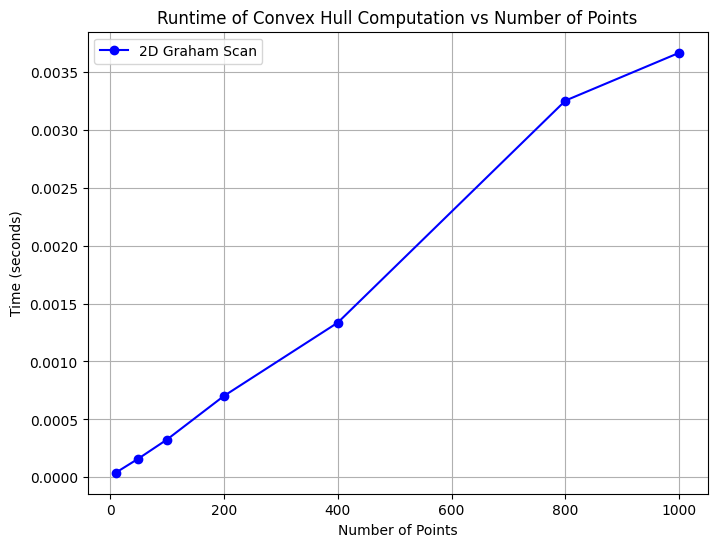

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(n_values, times, marker='o', color='b', linestyle='-', label='2D Graham Scan')
plt.xlabel('Number of Points')
plt.ylabel('Time (seconds)')
plt.title('Runtime of Convex Hull Computation vs Number of Points')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
# part c, bound points from -5 to 5
times = []

# Loop over each value of n
for n in n_values:
    # Generate random points
    points = generate_random_points(n, x_range=(-5, 5), y_range=(-5, 5))
    
    # Measure the time taken to compute the convex hull
    elapsed_time = measure_time_to_compute_hull(points)
    
    # Store the result
    times.append(elapsed_time)

print(times)

[4.00543212890625e-05, 0.00014853477478027344, 0.00035381317138671875, 0.001268625259399414, 0.005414247512817383, 0.0024313926696777344, 0.003937959671020508]


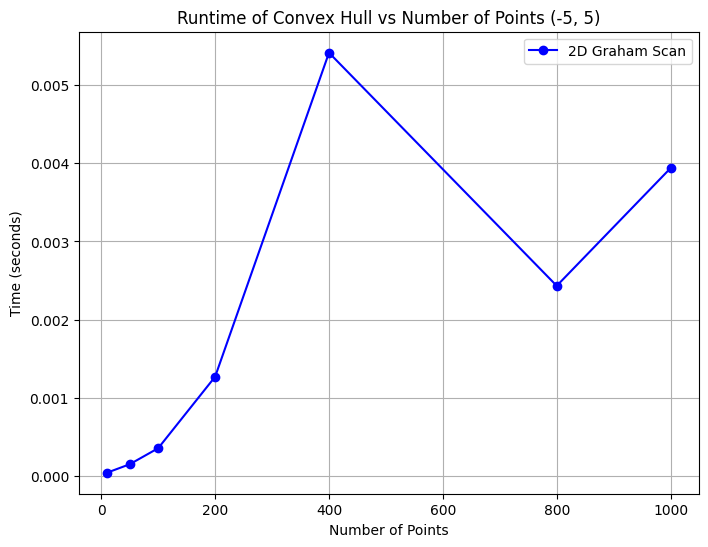

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(n_values, times, marker='o', color='b', linestyle='-', label='2D Graham Scan')
plt.xlabel('Number of Points')
plt.ylabel('Time (seconds)')
plt.title('Runtime of Convex Hull vs Number of Points (-5, 5)')
plt.grid(True)
plt.legend()
plt.show()

# Task 2

In [40]:
from collections import Counter
from scipy.spatial import Delaunay
np.isclose

<function numpy.isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)>

In [41]:
# Part a
def surface1(x, y):
    return 2*x**2+2*y**2

In [42]:
def surface2(x, y):
    return 2*np.exp(-x**2-y**2)

In [43]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
x, y = np.meshgrid(x, y)

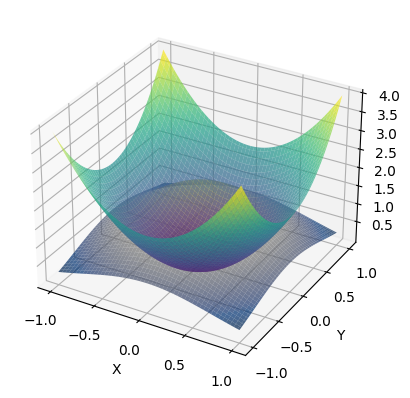

In [44]:
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot_surface(x, y, surface1(x, y), cmap='viridis', alpha=0.7)
ax.plot_surface(x, y, surface2(x, y), cmap='cividis', alpha=0.7)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [45]:
points = np.c_[x.ravel(), y.ravel()]
z1 = surface1(points[:, 0], points[:, 1])
print(points)

[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


In [46]:
# Part b
# points = generate_point_cloud(100)
# points = [x, y]
tri = Delaunay(points[:,:2])

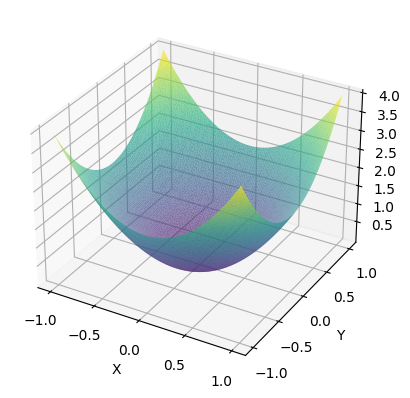

In [59]:
# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the surface using the triangulation
ax.plot_trisurf(points[:, 0], points[:, 1], z1, triangles=tri.simplices, cmap='viridis', alpha=0.7)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

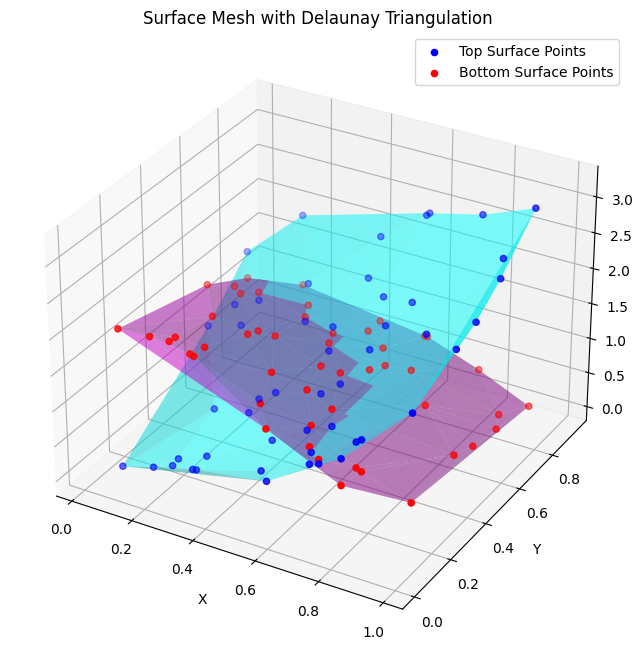

In [47]:
np.random.seed(0)  # For reproducibility
n_points = 50
points = np.random.rand(n_points, 2)  # n random points in 2D

# Apply Delaunay triangulation on the points
tri = Delaunay(points)

# Compute the top surface heights (z values for surface1)
top_z = surface1(points[:, 0], points[:, 1])

# Compute the bottom surface heights (z values for surface2)
bottom_z = surface2(points[:, 0], points[:, 1])

# Create the figure for 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the top surface mesh (triangles)
for simplex in tri.simplices:
    x = points[simplex, 0]
    y = points[simplex, 1]
    z = top_z[simplex]
    ax.plot_trisurf(x, y, z, color='cyan', alpha=0.5)

# Plot the bottom surface mesh (triangles)
for simplex in tri.simplices:
    x = points[simplex, 0]
    y = points[simplex, 1]
    z = bottom_z[simplex]
    ax.plot_trisurf(x, y, z, color='magenta', alpha=0.5)

# Plot the points on the surfaces
ax.scatter(points[:, 0], points[:, 1], top_z, color='blue', label="Top Surface Points")
ax.scatter(points[:, 0], points[:, 1], bottom_z, color='red', label="Bottom Surface Points")

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Mesh with Delaunay Triangulation')
ax.legend()

plt.show()

In [48]:
n_points = 100
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

In [49]:
X, Y = np.meshgrid(x, y)
points = np.vstack([X.ravel(), Y.ravel()]).T  # Stack to create an (n, 2) array

In [50]:
tri = Delaunay(points)

top_z = surface1(points[:, 0], points[:, 1])
bottom_z = surface2(points[:, 0], points[:, 1])

In [52]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the top surface mesh (triangles)
for simplex in tri.simplices:
    x = points[simplex, 0]
    y = points[simplex, 1]
    z = top_z[simplex]
    ax.plot_trisurf(x, y, z, color='cyan', alpha=0.5)

# Plot the bottom surface mesh (triangles)
for simplex in tri.simplices:
    x = points[simplex, 0]
    y = points[simplex, 1]
    z = bottom_z[simplex]
    ax.plot_trisurf(x, y, z, color='magenta', alpha=0.5)

# Plot the points on the surfaces
ax.scatter(points[:, 0], points[:, 1], top_z, color='blue', label="Top Surface Points")
ax.scatter(points[:, 0], points[:, 1], bottom_z, color='red', label="Bottom Surface Points")

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Mesh with Delaunay Triangulation')
ax.legend()

plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f20f4f24ca0> (for post_execute):


KeyboardInterrupt: 